In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [188]:
df = pd.read_csv('./adult19.csv')
df.head()

,URBRRL,RATCAT_A,INCGRP_A,INCTCFLG_A,FAMINCTC_A,IMPINCFLG_A,PPSU,PSTRAT,HISPALLP_A,RACEALLP_A,...,PROXYREL_A,PROXY_A,AVAIL_A,HHSTAT_A,INTV_QRT,RECTYPE,WTFA_A,WTIA_A,HHX,POVRATTC_A
0,4,9,3,0,60000,2,2,122,3,2,...,NaN,NaN,1,1,1,10,13177.008,7601.336,H048109,2.96
1,4,9,3,0,50000,0,2,122,2,1,...,NaN,NaN,1,1,1,10,6140.552,3344.434,H027044,2.97
2,4,12,3,0,65000,1,2,122,2,1,...,NaN,NaN,1,1,1,10,9191.061,6949.498,H058855,4.28
3,4,14,5,0,120000,0,2,122,1,8,...,NaN,NaN,1,1,1,10,7900.035,6446.327,H031993,7.13
4,1,4,1,0,30000,0,2,115,2,1,...,NaN,NaN,1,1,1,10,10875.772,8646.586,H007122,1.13


In [189]:
# finding columns with more than half of values missing and dropping them
most_nulls = [column for column in df.columns if df[column].isnull().sum() > 16_000]
df.drop(columns=most_nulls, inplace=True)

In [190]:
df.shape

(31997, 243)

In [191]:
# changing values in target column to don't know(9) if not yes(1) or no(2) and changing no to 0
df['CHDEV_A'] = df['CHDEV_A'].replace([2,7,8], [0,9,9])
# dropping rows that aren't yes or no in target column
target_unknown = df[df['CHDEV_A'] == 9]
df.drop(target_unknown.index, inplace=True)

In [192]:
df.shape

(31894, 243)

In [132]:
# df.fillna(9, inplace=True)

In [193]:
# changing datatypes for all columns except the target to objects so they can be dummified since they are categorical values
df = df.astype(object)
df['CHDEV_A'] = df['CHDEV_A'].astype(int)

In [194]:
# defining X and y variables for modeling
X = df[['SMKCIGST_A','HISPALLP_A', 'SEX_A', 'AFNOW', 'EMPWRKLSWK_A', 'MEDICARE_A', 'OVER65FLG_A', 'INCSSRR_A', 'HIKIND02_A', 'MIEV_A', 'ANGEV_A', 'CHLEV_A', 'HYPEV_A']]
y = df['CHDEV_A']

In [195]:
# dummifying X variable features
X_dum = pd.get_dummies(X, drop_first=True)

In [196]:
X_dum

,SMKCIGST_A_2,SMKCIGST_A_3,SMKCIGST_A_4,SMKCIGST_A_5,SMKCIGST_A_9,HISPALLP_A_2,HISPALLP_A_3,HISPALLP_A_4,HISPALLP_A_5,HISPALLP_A_6,...,MIEV_A_2,MIEV_A_9,ANGEV_A_2,ANGEV_A_9,CHLEV_A_2,CHLEV_A_7,CHLEV_A_9,HYPEV_A_2,HYPEV_A_7,HYPEV_A_9
0,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
2,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31992,0,1,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
31993,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
31994,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
31995,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


In [227]:
X_kbchoice = X_dum[['SMKCIGST_A_3','AFNOW_2.0','EMPWRKLSWK_A_2','MEDICARE_A_3','OVER65FLG_A_1','INCSSRR_A_2.0','HIKIND02_A_2','MIEV_A_2','ANGEV_A_2','CHLEV_A_2','HYPEV_A_2']]

In [231]:
X_kbchoice.shape

(31894, 11)

In [217]:
# choosing top 10 best predicting columns for modeling
kb = SelectKBest(k=11)
X_kb = kb.fit_transform(X_dum, y)

In [218]:
# splitting data into train and test sets for X and y variables
X_train, X_test, y_train, y_test = train_test_split(X_kb, y, stratify=y, random_state=19)

In [219]:
# creating balanced classes for train data
sm = SMOTEN(random_state=19)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [220]:
X_train_res.shape, y_train_res.shape

((45072, 11), (45072,))

In [221]:
lrsm = LogisticRegression(max_iter=1000, random_state=19)
lrsm.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=19)

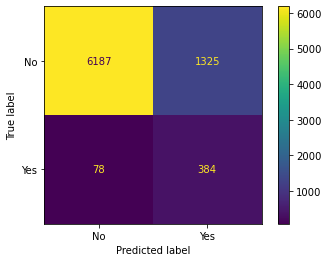

In [222]:
preds = lrsm.predict(X_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes']).plot();

In [223]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      7512
           1       0.22      0.83      0.35       462

    accuracy                           0.82      7974
   macro avg       0.61      0.83      0.63      7974
weighted avg       0.94      0.82      0.87      7974



In [224]:
lrsm.score(X_train_res, y_train_res), lrsm.score(X_test, y_test)

(0.8155617678381256, 0.8240531728116378)

In [226]:
coef_df = pd.DataFrame({'coefs': lrsm.coef_[0], 'features': kb.get_support(indices=True)})
coef_df['feature_names'] = [X_dum.columns[i] for i in coef_df['features']] 
coef_df['questions'] = ['former smoker','no one on active duty', 'did not work last week', 'not on medicare', 'one person in home over 65', 'no income from railroad',
                       'health insurance not mentioned', 'no heart attack',  'no angina', 'no high cholesterol', 'no hypertension']
coef_df

,coefs,features,feature_names,questions
0,0.050810,1,SMKCIGST_A_3,former smoker
1,-0.181496,13,AFNOW_2.0,no one on active duty
2,0.689913,16,EMPWRKLSWK_A_2,did not work last week
3,-0.221597,19,MEDICARE_A_3,not on medicare
4,0.265454,23,OVER65FLG_A_1,one person in home over 65
5,-0.359526,24,INCSSRR_A_2.0,no income from railroad
6,-0.270067,28,HIKIND02_A_2,health insurance not mentioned
7,-3.372043,31,MIEV_A_2,no heart attack
8,-2.506370,33,ANGEV_A_2,no angina
9,-0.722304,35,CHLEV_A_2,no high cholesterol
